# This notebook plots OBS MCS rain fraction map and regional mean barchart from different trackers
## The data is produced by:
- /src/calc_tbpf_mcs_rainmap_mcsmip.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
import colorcet as cc
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import copy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

source = 'OBS'
# source = 'OBSv7'

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'
dir_TOOCAN = f'{rootdir}TOOCAN/'
dir_tobac = f'{rootdir}tobac/'
dir_TAMS = f'{rootdir}TAMS/'
dir_simpleTrack = f'{rootdir}simpleTrack/'
dir_KFyAO = f'{rootdir}KFyAO/'
dir_DL = f'{rootdir}DL/'
dir_ATRACKCS = f'{rootdir}ATRACKCS/'

dict_filenames = {
    'PyFLEXTRKR': f'{dir_PyFLEXTRKR}mcs_rainmap_{PHASE}_{source}.nc',
    'MOAAP': f'{dir_MOAAP}mcs_rainmap_{PHASE}_{source}.nc',
    'TOOCAN': f'{dir_TOOCAN}mcs_rainmap_{PHASE}_{source}.nc',
    'tobac': f'{dir_tobac}mcs_rainmap_{PHASE}_{source}.nc',
    'TAMS': f'{dir_TAMS}mcs_rainmap_{PHASE}_{source}.nc',
    'simpleTrack': f'{dir_simpleTrack}mcs_rainmap_{PHASE}_{source}.nc',
    'DL': f'{dir_DL}mcs_rainmap_{PHASE}_{source}.nc',
    'KFyAO': f'{dir_KFyAO}mcs_rainmap_{PHASE}_{source}.nc',
    # 'ATRACKCS': f'{dir_ATRACKCS}mcs_rainmap_{PHASE}_{source}.nc',
}

filenames = list(dict_filenames.values())
tracker_list = list(dict_filenames.keys())

topfile = '/global/cfs/cdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'
landmaskfile = '/pscratch/sd/f/feng045/DYAMOND/maps/IMERG_landmask_180W-180E_60S-60N.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/


## Check if input files exist

In [3]:
for key, value in dict_filenames.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_rainmap_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_rainmap_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_rainmap_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_rainmap_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_rainmap_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_rainmap_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_rainmap_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_rainmap_Summer_OBS.nc: True


# These customed functions enables use of [NCL colormaps](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml)

In [4]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

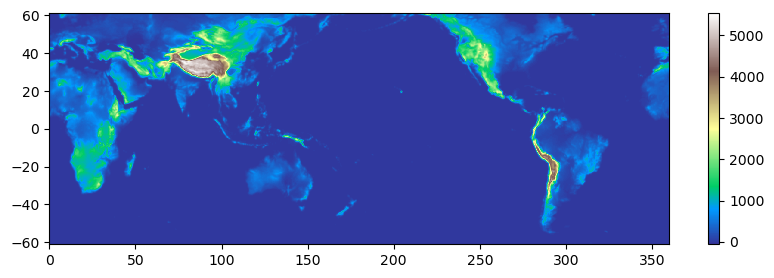

In [5]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))

fig = plt.figure(figsize=[10,3], dpi=100)
plt.pcolormesh(lon_ter, lat_ter, ter_s, cmap='terrain')
plt.colorbar()

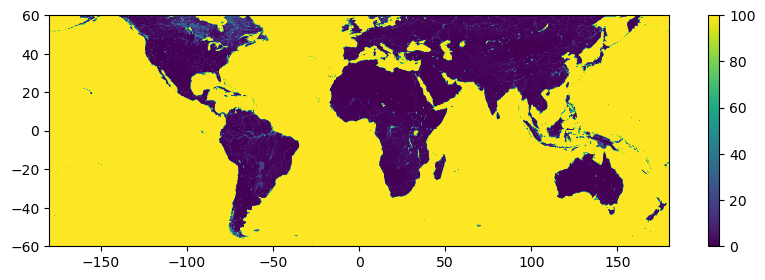

In [6]:
# Read landmask data
dslm = xr.open_dataset(landmaskfile)
lon_lm = dslm['lon']
lat_lm = dslm['lat']
# dslm = dslm.assign_coords(lon=lon_obs)
# dslm = dslm.assign_coords(lat=lat_obs)
# if PHASE == 'Winter':
#     dslm = dslm.roll(lon=1800, roll_coords=True)
#     dslm = dslm.assign_coords(lon=lon_obs)
#     dslm = dslm.assign_coords(lat=lat_obs)
    
landmask = dslm.landseamask
fig = plt.figure(figsize=[10,3], dpi=100)
plt.pcolormesh(lon_lm, lat_lm, landmask)
plt.colorbar()

# Read and combine all files to a single DataSet

In [7]:
drop_vars = ['latitude', 'longitude', 'lat', 'lon']
# Read all files and combine them with a new dimension 'tracker'
ds = xr.open_mfdataset(filenames, combine='nested', concat_dim='tracker', drop_variables=drop_vars).squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds['tracker'] = tracker_list
# Assign lat/lon coordinate from landmask
ds = ds.assign_coords({'lon': lon_lm, 'lat': lat_lm})

if PHASE == 'Winter':
    ds = ds.roll(lon=1800, roll_coords=True)
    # Convert longitude coordinates from -180~180 to 0~360
    lon360 = ds['lon'].data % 360
    ds = ds.assign_coords(lon=lon360)

lon = ds.lon
lat = ds.lat
ds

<xarray.Dataset>
Dimensions:                  (tracker: 8, lat: 1200, lon: 3600)
Coordinates:
    time                     datetime64[ns] 2016-08-10
  * tracker                  (tracker) <U11 'PyFLEXTRKR' 'MOAAP' ... 'KFyAO'
  * lon                      (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
Data variables:
    precipitation            (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation        (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation_count  (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_cloud_count          (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ntimes                   (tracker) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Title:       MCS precipitation accumulation
    phase:       Summer
    tracker:     PyFLEXTRKR
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2016-08-10T00
    end_date:    2016-09-10T00
    created_on:  Mon Nov  6 13:46:23 2023

In [8]:
ds.lon

<xarray.DataArray 'lon' (lon: 3600)>
array([-179.95, -179.85, -179.75, ...,  179.75,  179.85,  179.95])
Coordinates:
    time     datetime64[ns] 2016-08-10
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.8 179.9
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    axis:           X
    modulo:         360.0
    topology:       circular
    valid_min:      -180.0
    valid_max:      180.0
    bounds:         lon_bnds

## Calculate statistics

In [9]:
# Total number of hours
nhours = ds.ntimes
# nhours_pyflex.values
print(f'Number of total hours')
for key in tracker_list:
    print(f'{key}: {int(nhours.sel(tracker=key).values.item())}')
# Precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp = 24. * ds.precipitation / nhours
mcspcp = 24. * ds.mcs_precipitation / nhours
nonmcspcp = totpcp - mcspcp
# MCS precipitation fraction
mcspcpfrac = 100 * mcspcp / totpcp

# Number of hours with MCS precipitation/cloud
mcspcphours = ds.mcs_precipitation_count
mcscloudhours = ds.mcs_cloud_count
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity = ds.mcs_precipitation / mcspcphours

# MCS precipitation frequency
mcspcpfreq = 100 * (mcspcphours / nhours)
mcscloudfreq = 100 * (mcscloudhours / nhours)

Number of total hours
PyFLEXTRKR: 744
MOAAP: 744
TOOCAN: 743
tobac: 744
TAMS: 744
simpleTrack: 744
DL: 744
KFyAO: 744


/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


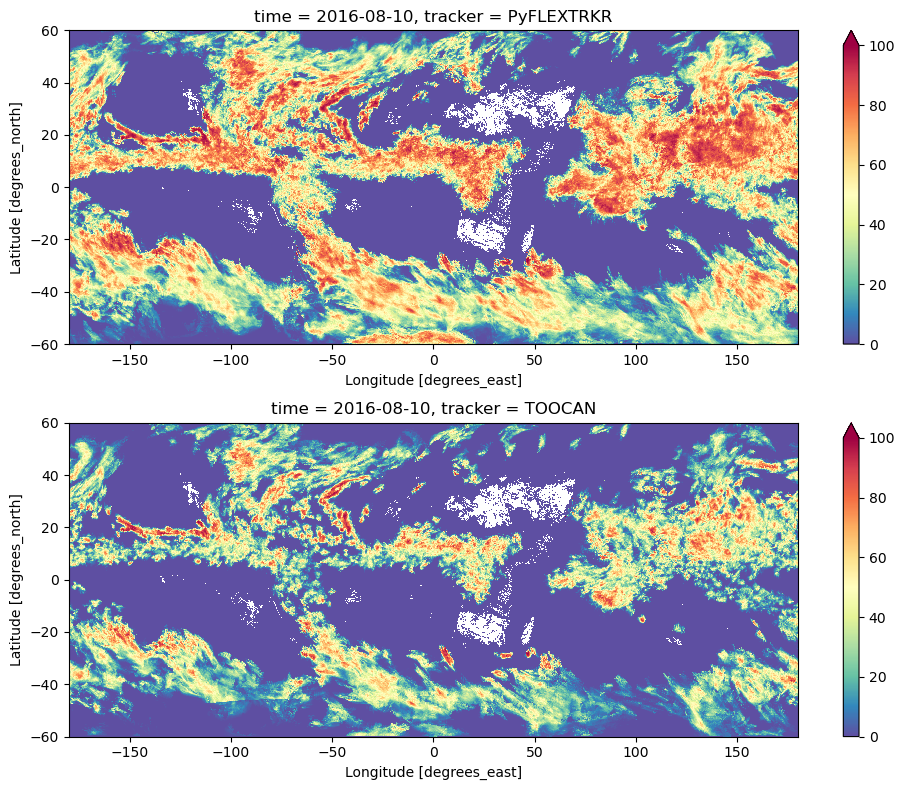

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
mcspcpfrac.sel(tracker='PyFLEXTRKR').plot(vmin=0, vmax=100, cmap='Spectral_r', ax=axes[0])
mcspcpfrac.sel(tracker='TOOCAN').plot(vmin=0, vmax=100, cmap='Spectral_r', ax=axes[1])
fig.tight_layout()

## Specify regional boundaries for calculating mean values

In [11]:
if PHASE == 'Summer':
    box_mc = [95,150,-20,5]
    box_itcz = [-179,-70,5,18]
    box_io = [58,96,-10,5]
    box_wpac = [125,178,0,30]
    box_sam = [70,125,5,40]
    box_afc = [-15,40,-5,18]
    # box_amz = [-75,-40,-20,0]
    box_amz = [-75,-45,-15,5]
    box_ao = [-60,-15,5,18]
    # box_cus = [-105, -80, 30, 50]
    box_cus = [-105, -85, 30, 50]
    box_ao180 = [-60,-15,5,18]
    box_cus180 = [-105, -80, 30, 50]
    boxes = {
        'WP':box_wpac,
        'ITCZ':box_itcz, 
        'IO':box_io, 
        'AO':box_ao,
        'AFC':box_afc, 
        'SAM':box_sam,
        'CUS':box_cus,
        'AMZ':box_amz,
    }
    region_names = dict(zip(boxes.keys(), boxes.keys()))
    
    # Calculate regional mean difference
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['WP'][3]+3,
        boxes['ITCZ'][3]+3, 
        boxes['IO'][2]-6, 
        boxes['AO'][3]+3,
        boxes['AFC'][2]-6, 
        boxes['SAM'][3]+3,
        boxes['CUS'][3]+3,
        boxes['AMZ'][2]-6,
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [12]:
if PHASE == 'Winter':
    box_mc = [95%360,150%360,-15,5]
    box_itcz = [151%360,-110%360,0,12]
    box_spcz = [151%360,-150%360,-30,-1]
    box_io = [50%360,94%360,-15,5]
    box_afc = [10%360,40%360,-20,5]
    box_amz = [-75%360,-40%360,-20,0]
    box_ses = [-68%360,-47%360,-40,-21]
    box_ao = [-40%360,-10%360,-8,8]
    # box_amz180 = [-75,-40,-20,0]
    # box_ao180 = [-40,-10,-8,8]
    boxes = {
        'MC':box_mc, 
        'ITCZ':box_itcz, 
        'SPCZ':box_spcz, 
        'IO':box_io, 
        'AO':box_ao,
        'AFC':box_afc, 
        'AMZ':box_amz,
        'SES':box_ses,
    }
    region_names = dict(zip(boxes.keys(), boxes.keys()))

    # Calculate regional mean difference
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['MC'][3]+3,
        boxes['ITCZ'][3]+3,
        boxes['SPCZ'][2]-6, 
        boxes['IO'][2]-6, 
        boxes['AO'][3]+3,
        boxes['AFC'][2]-6, 
        boxes['AMZ'][3]+3, 
        boxes['SES'][2]-6,
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [13]:
text_loc

{'WP': (151.5, 33),
 'ITCZ': (-124.5, 21),
 'IO': (77.0, -16),
 'AO': (-37.5, 21),
 'AFC': (12.5, -11),
 'SAM': (97.5, 43),
 'CUS': (-95.0, 53),
 'AMZ': (-60.0, -21)}

In [14]:
boxes

{'WP': [125, 178, 0, 30],
 'ITCZ': [-179, -70, 5, 18],
 'IO': [58, 96, -10, 5],
 'AO': [-60, -15, 5, 18],
 'AFC': [-15, 40, -5, 18],
 'SAM': [70, 125, 5, 40],
 'CUS': [-105, -85, 30, 50],
 'AMZ': [-75, -45, -15, 5]}

## Function to calculate regional mean

In [15]:
def calc_regional_mean(da, boxes):
    """
    Calculate regional mean for all trackers
    Args:
        da: DataArray
            Data Array containing dimensions (tracker, lat, lon)
        boxes: dictionary
            Dictionary containing region names and lat/lon bounds
        
    Returns:
        dict_out: dictionary
            Dictionary containing mean difference for each box.
    """
    # Get number of trackers
    ntracker = da.sizes['tracker']
    # Get number of boxes
    nbox = len(boxes)
    # Get tracker names
    tracker_names = list(da.tracker.data[:])
    
    # Make arrays to store the differences
    mean_reg = np.zeros((ntracker,nbox), dtype=float)
    dict_out = {}
    
    # Loop over each region
    for ii, name in enumerate(boxes):       
        # Select (subset) the region
        ida = da.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)
        # Average over the region
        mean_reg[:,ii] = ida.mean(dim=('lat','lon'))
        
    # Put values in dictionary
    dict_out = dict(zip(tracker_names, mean_reg))
   
    return dict_out

In [16]:
dict_mcspcpfracAvg = calc_regional_mean(mcspcpfrac, boxes)
dict_mcspcpfracAvg

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/co

{'PyFLEXTRKR': array([66.45851135, 51.90022278, 56.13817215, 48.64002609, 46.08206177,
        46.74586868, 54.72605133, 34.55446625]),
 'MOAAP': array([50.08547974, 37.32915497, 41.43427658, 34.53191757, 30.98350334,
        30.9546566 , 33.42538071, 17.65965843]),
 'TOOCAN': array([38.49953461, 26.19962883, 32.76836777, 24.24223709, 27.73431396,
        24.81671715, 34.72583771, 13.50172997]),
 'tobac': array([39.45914078, 33.25872421, 28.64120674, 31.47017097, 28.8446312 ,
        25.36355591, 27.33778191, 15.04711246]),
 'TAMS': array([67.47146606, 51.33178329, 60.36158752, 48.24724197, 40.58279037,
        46.37231445, 41.25318146, 28.84572983]),
 'simpleTrack': array([59.79327011, 46.75709152, 51.75246429, 43.82422638, 42.061409  ,
        41.88354492, 48.23429871, 31.53832626]),
 'DL': array([66.83799744, 38.11026764, 46.06698227, 45.45451355, 43.24656677,
        33.47764969, 18.32689476, 24.42190552]),
 'KFyAO': array([57.9420433 , 43.15991974, 44.59202957, 39.5594368 , 37.632

## Function to plot 1 map and bar chart

In [17]:
def plot_map_bars(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                  oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None,
                  boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None,
                  bar_data=None, bar_width=None, bar_ylabel=None, legend_prop=None, bar_ylim=None, bar_yticks=None,):
                  # boxes=None, boxtextloc=None, dict_text_type=None, dict_text_val=None, text_colors=None, boxtext_fontsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    ###################################################
    # Map plot
    ###################################################
    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    h_ratios = [0.05, 1, 1]
    gs = gridspec.GridSpec(3, 1, height_ratios=h_ratios, width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.3)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    ax = plt.subplot(gs[1,0], projection=proj)
    ax.set_extent(map_extent, crs=proj)
    ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(titles[0], loc='left')
    
    # Grid lines & labels
    gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)         
    # if (row == nrow-1):
    ax.set_xticks(lonv, crs=data_proj)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_yticks(latv, crs=data_proj)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    # Terrain height
    ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                    colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
    
    # Select and mask data source
    Zm = np.ma.masked_where(np.isnan(data_map), data_map)
    cmap = copy.copy(mpl.colormaps.get_cmap(cmaps))
    # Set out-of-bounds colors
    if oob_colors is not None:
        cmap.set_over(oob_colors['over'])
        cmap.set_under(oob_colors['under'])
        # cf1.set_clim(min(levels), max(levels))
    norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    # Plot data
    if (contourf == False):
        cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
    else:
        cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
    # # Set out-of-bounds colors
    # if oob_colors is not None:
    #     cf1.cmap.set_over(oob_colors['over'])
    #     cf1.cmap.set_under(oob_colors['under'])
    #     cf1.set_clim(min(levels), max(levels))
    # Colorbars
    cax1 = plt.subplot(gs[0,0])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels, ticks=cbticks, orientation='horizontal', extend='both')
    cb1.ax.xaxis.set_label_position('top')
    cb1.ax.tick_params(labelsize=cb_fontsize)
        
    # Plot boxes
    if boxes is not None:
        for ii in boxes:
            # Plot region boxes
            corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
            box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
            ax.add_patch(box)

            if boxtexttype is None:
                text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
            else:
                text_color = 'k'
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)

    
    ###################################################
    # Bar chart
    ###################################################
    ax2 = plt.subplot(gs[2,0])
    labels = list(boxes.keys())
    x = np.arange(len(labels))
    multiplier = -((len(tracker_list)-1)/2)
    lcolors = {
        'PyFLEXTRKR':'royalblue', 
        'MOAAP': 'darkorange',
        'TOOCAN': 'gold', 
        'tobac': 'cyan',
        'TAMS': 'violet', 
        'simpleTrack': 'lightseagreen',
        'DL': 'blueviolet',
        'KFyAO': 'peru',
        'ATRACKCS': 'lime',
    }

    # Loop over each source    
    for key, val in bar_data.items():
        offset = bar_width * multiplier
        rects = ax2.bar(x + offset, val, bar_width, color=lcolors[key], label=key)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel(bar_ylabel)
    ax2.set_title(titles[1], loc='left')
    ax2.set_xticks(x, labels)
    ax2.set_yticks(bar_yticks)
    ax2.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'])
    ax2.axhline(y=0, lw=1, ls='--', color='k')
    ax2.grid(which='major', ls='--', axis='y')
    ax2.set_ylim(bar_ylim[0], bar_ylim[1])
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [18]:
dict_mcspcpfracAvg.keys()

dict_keys(['PyFLEXTRKR', 'MOAAP', 'TOOCAN', 'tobac', 'TAMS', 'simpleTrack', 'DL', 'KFyAO'])

In [19]:
if PHASE == 'Summer':
    panel_numbers = ['(a)', '(c)']
elif PHASE == 'Winter':
    panel_numbers = ['(b)', '(d)']
print(panel_numbers)

['(a)', '(c)']


In [20]:
int(len(tracker_list)/2)

4

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


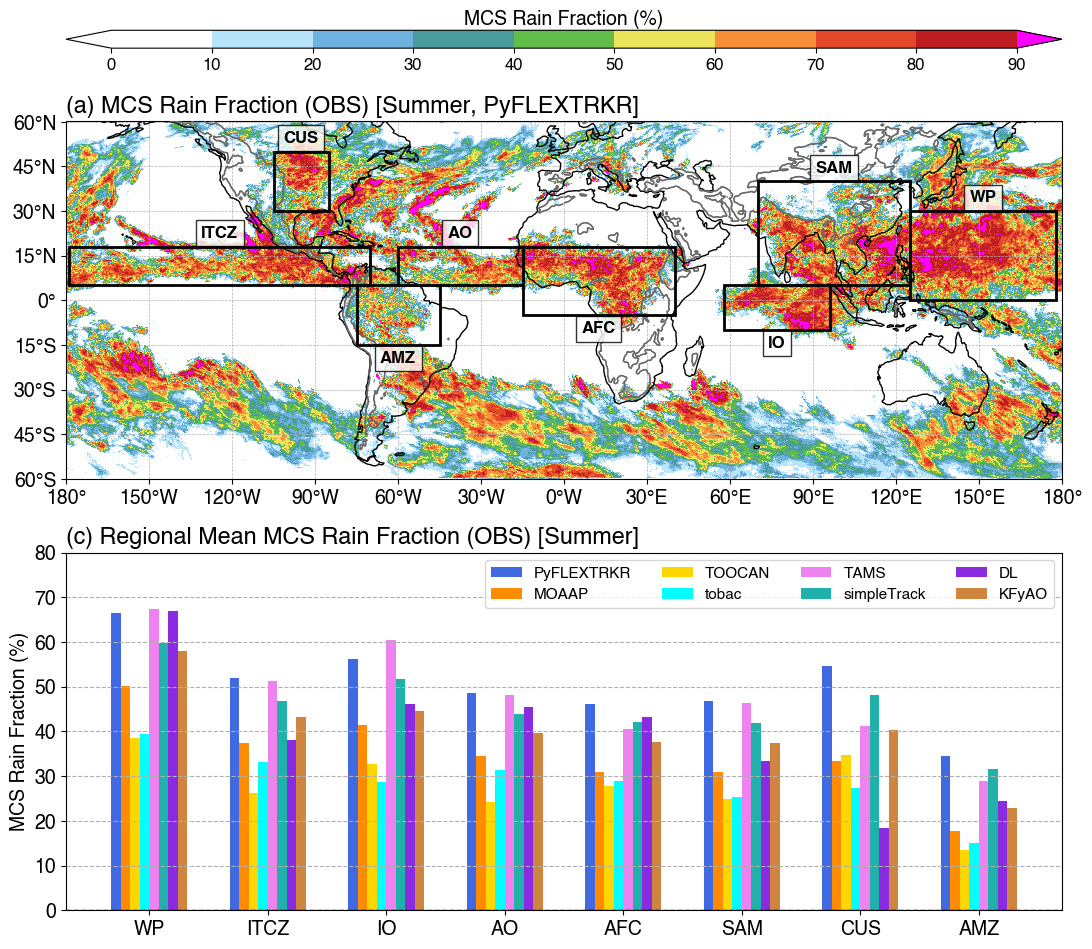

In [21]:
figsize = [12,11]
fontsize = 14
cb_fontsize = 12
varname1 = 'MCS Rain Fraction'
varname2 = 'MCS Rain Fraction'
units = '%'

# Map data
tracker = 'PyFLEXTRKR'
data_map = mcspcpfrac.sel(tracker=tracker)
levels = np.arange(0, 90.01, 10)
cmaps = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmaps = truncate_colormap(cmaps, 0.0, 0.9)
titles = [f'{panel_numbers[0]} {varname1} ({source}) [{PHASE}, {tracker}]', f'{panel_numbers[1]} Regional Mean {varname1} ({source}) [{PHASE}]']
cbticks = levels
oob_colors = {'under':'white', 'over':'magenta'}
cblabels = f'{varname1} ({units})'
text_colors = None
text_val = dict(zip(boxes.keys(),boxes.keys()))

# Bar chart data
bar_data = dict_mcspcpfracAvg
bar_ylabel = f'{varname2} (%)'
bar_ylim = (0,80)
bar_yticks = np.arange(0, 81, 10)
legend_prop = {'ncol':int(len(tracker_list)/2), 'fontsize':11}
bar_width = 0.08

figname = f'{figdir}globalmap_mcs_rainfrac_{source}_barchart_regionalmean.png'

fig = plot_map_bars(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
                    bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_yticks=bar_yticks)

In [22]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/globalmap_mcs_rainfrac_OBS_barchart_regionalmean.png'

## Function to plot multiple panels

In [23]:
def plot_maps_nrow(nrow, ncol, da, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                   oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None, show_cb2=False, figtitle=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    # Setup two columns (left: plots, right: colorbar)
    gs0 = gridspec.GridSpec(1, 2, figure=fig, height_ratios=[1], width_ratios=[1,0.02], wspace=0.05)
    # Setup panels to the left
    h_ratios = list(np.repeat(1,nrow))
    w_ratios = list(np.repeat(1,ncol))
    gs = gridspec.GridSpecFromSubplotSpec(nrow, ncol, subplot_spec=gs0[0], height_ratios=h_ratios, width_ratios=w_ratios, wspace=0.02, hspace=0.05)
    
    # Loop over each panel (DataArray dimension 'tracker')
    for pp in range(da.sizes['tracker']):
        ax = plt.subplot(gs[pp], projection=proj)
        ax.set_extent(map_extent, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_aspect('auto', adjustable=None)
        # Title
        flabel = ax.text(0.02, 0.07, titles[pp], transform=ax.transAxes, fontsize=None)
        flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
        
        # Grid lines & labels
        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        # gl.xlocator = mpl.ticker.FixedLocator(lonv)
        # gl.ylocator = mpl.ticker.FixedLocator(latv)         
        # if (row == nrow-1):
        #     ax.set_xticks(lonv, crs=data_proj)
        #     lon_formatter = LongitudeFormatter(zero_direction_label=True)
        #     ax.xaxis.set_major_formatter(lon_formatter)
        # ax.set_yticks(latv, crs=data_proj)
        # lat_formatter = LatitudeFormatter()
        # ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=levelshgt, \
                        colors='dimgray', linewidths=0.5, transform=data_proj, zorder=3)
        
        # Select and mask data source
        Var = da.isel(tracker=pp).data
        Zm = np.ma.masked_where(np.isnan(Var), Var)
        cmap = copy.copy(mpl.colormaps.get_cmap(cmaps))
        # Set out-of-bounds colors
        if oob_colors is not None:
            oob_c = oob_colors
            if oob_c is not None:
                cmap.set_over(oob_c['over'])
                cmap.set_under(oob_c['under'])
        norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
        # Plot data
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)

    # Colorbar
    cax = plt.subplot(gs0[1])
    cbar = plt.colorbar(cf1, cax=cax, label=cblabels, ticks=cbticks, orientation='vertical', extend='both')
    # Suptitle
    fig.suptitle(figtitle, y=0.92)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [24]:
if PHASE == 'Summer':
    panel_number = '(a)'
elif PHASE == 'Winter':
    panel_number = '(b)'
print(panel_number)

(a)


/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/co

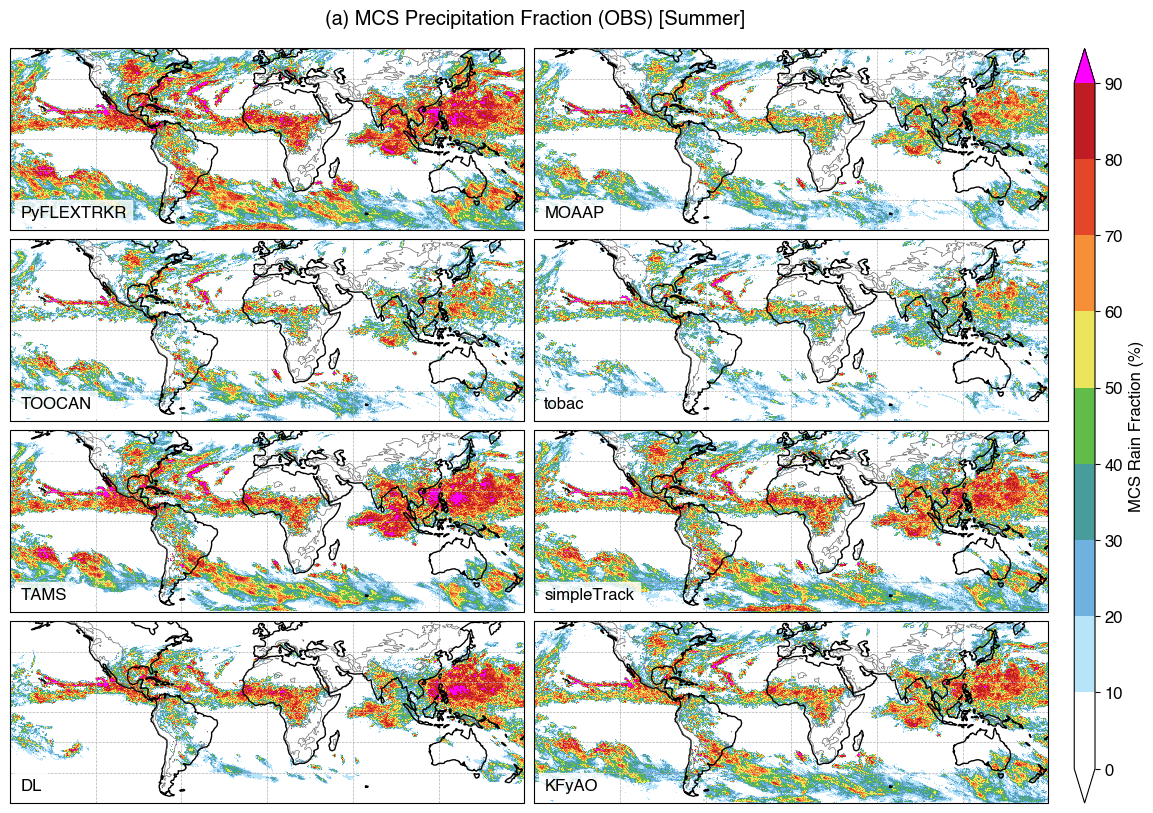

In [25]:
ncol = 2
nsource = len(tracker_list)
nrow = np.ceil(nsource / ncol).astype(int)

figwidth = 14
height_ratio_per_panel = 0.35
figheight = nrow * (figwidth / ncol) * height_ratio_per_panel
figsize = [figwidth,figheight]
fontsize = 12
cb_fontsize = 10
varname1 = 'MCS Rain Fraction'
units = '%'

# Select variable to plot
da = mcspcpfrac
levels = np.arange(0, 90.01, 10)
cmaps = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmaps = truncate_colormap(cmaps, 0.0, 0.9)
titles = tracker_list
figtitle = f'{panel_number} MCS Precipitation Fraction ({source}) [{PHASE}]'

cbticks = levels
oob_colors = {'under':'white', 'over':'magenta'}
cblabels = f'{varname1} ({units})'
figname = f'{figdir}globalmap_mcs_rainfrac_{source}_alltrackers.png'

fig = plot_maps_nrow(nrow, ncol, da, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, figtitle=figtitle,
                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, show_cb2=False)

In [26]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/globalmap_mcs_rainfrac_OBS_alltrackers.png'

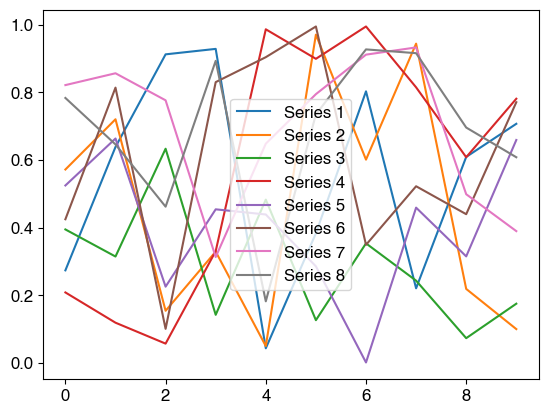

In [27]:
# import matplotlib.pyplot as plt
# import numpy as np

x = np.arange(10)
y = np.random.rand(10, 8)  # Random data for 8 series

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
          'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

for i in range(8):
    plt.plot(x, y[:, i], label=f'Series {i+1}', color=colors[i])

plt.legend()
plt.show()
